# Trading Systems Development
### - The first trading system based on the Exponential Moving Average (EMA) and Moving average convergence/divergence (MACD) indicator.
### - The second algorithm based on a combination of MACD and RSI indicators. 
### - The third one based on a combination of  RSI indicator and an other "indicator". The basis of this "indicator" is the Gaussian like distribution of the close price changes.

## Summary
### - The final equities are 257398.2, 455316.85 and 645539.03 for first, second and third strategy.
### - The equity is higher than the benchmark equity till 2020 at the second strategy. After 2020 its lower.
### - The equity is always higher than the benchmark equity at the third strategy.
### - Use the whole budget at every trade.

### First, import packages/libraries.

In [1]:
import yfinance as yf # With yfinance library we can get data about stocks/ETFs.
import pandas as pd   # Pandas for data manipulation.
import numpy as np    # Make arrays.
import matplotlib.pyplot as plt # To make plots.
import pandas_ta as ta # Pandas_ta: technical analysis indicators.
import talib
from datetime import datetime

## First algorithm

### Get the history data of 'SPY' using the yfinance library.

In [2]:
spy = yf.Ticker('SPY').history(period='max')  # Get the history data of 'SPY'.
spy

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
1993-01-29 00:00:00-05:00,24.781352,24.781352,24.658061,24.763739,1003200,0.0,0.0,0.0
1993-02-01 00:00:00-05:00,24.781345,24.939861,24.781345,24.939861,480500,0.0,0.0,0.0
1993-02-02 00:00:00-05:00,24.922260,25.010325,24.869422,24.992712,201300,0.0,0.0,0.0
1993-02-03 00:00:00-05:00,25.027933,25.274514,25.010320,25.256901,529400,0.0,0.0,0.0
1993-02-04 00:00:00-05:00,25.344970,25.415422,25.063164,25.362583,531500,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-05-06 00:00:00-04:00,513.750000,516.609985,513.299988,516.570007,47264700,0.0,0.0,0.0
2024-05-07 00:00:00-04:00,517.559998,518.570007,516.450012,517.140015,52561300,0.0,0.0,0.0
2024-05-08 00:00:00-04:00,515.260010,517.739990,515.140015,517.190002,42047200,0.0,0.0,0.0


In [3]:
spy = spy['2000-01-01':]

### Plot the Close price and Volume over time

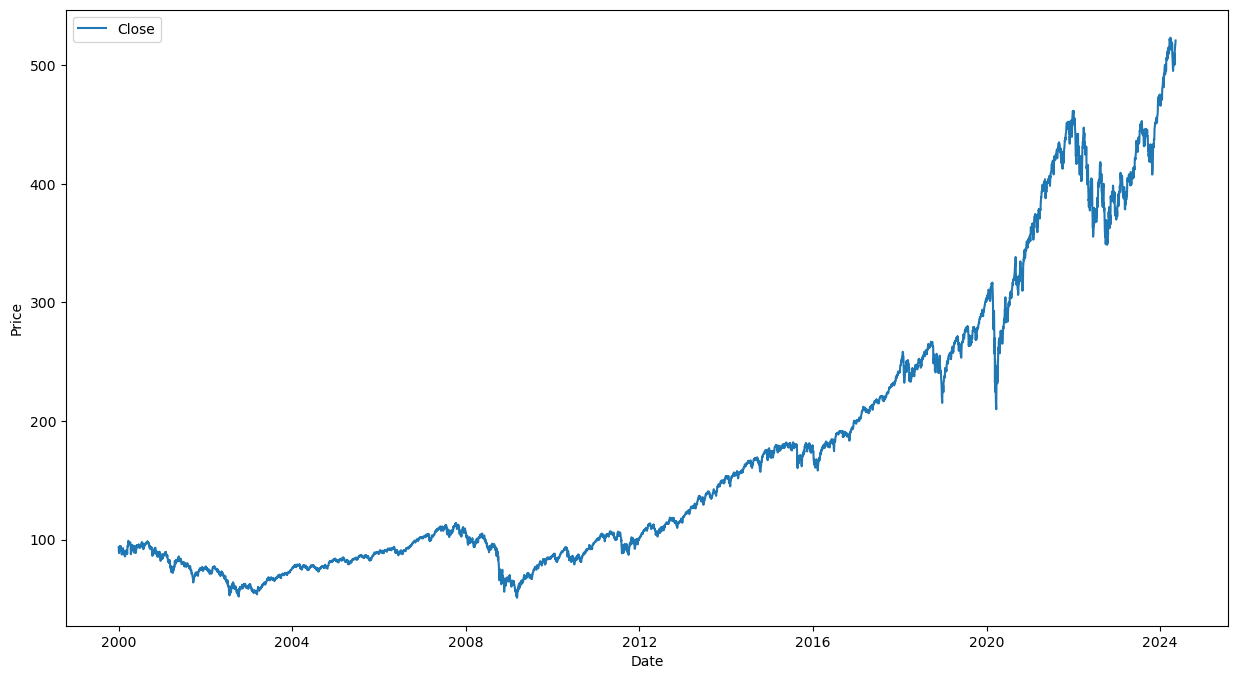

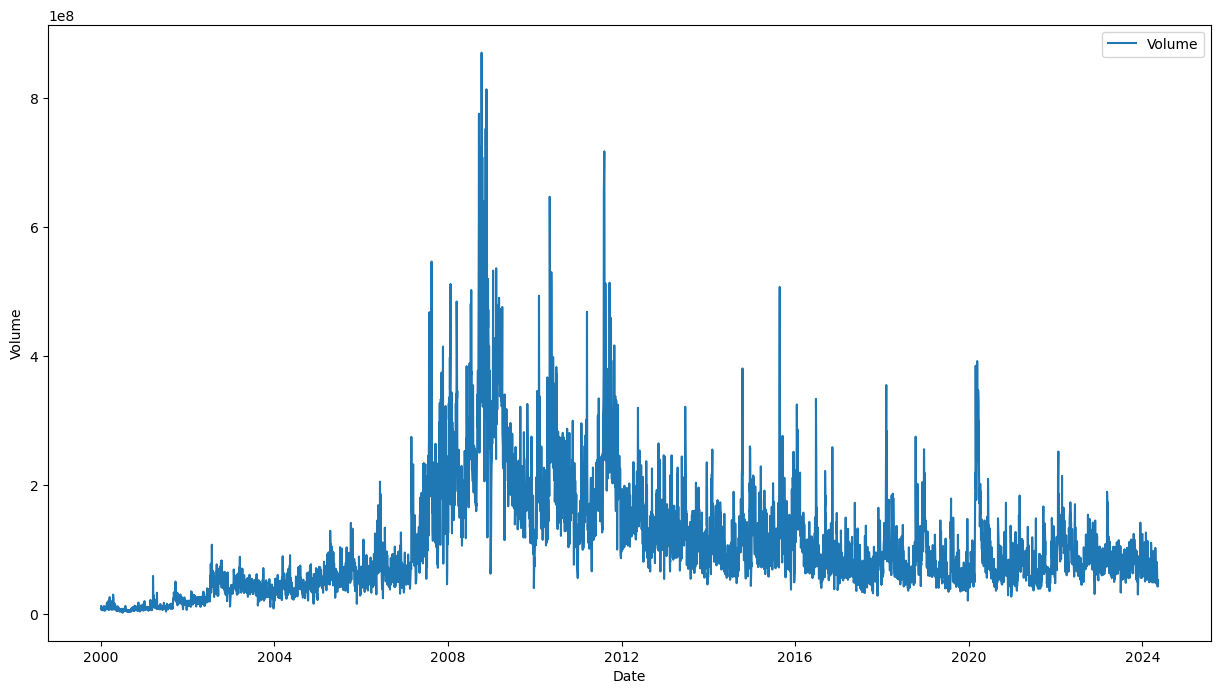

In [4]:
plt.figure(figsize = (15,8))
plt.plot(spy.index, spy['Close'], label = 'Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show

plt.figure(figsize = (15,8))
plt.plot(spy.index, spy['Volume'], label = 'Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

In [5]:
spy = spy.copy() # Make a copy to avoid copy warnings.

### Calculate the EMAs and MACD

In [6]:
spy["EMA12"] = ta.ema(spy["Close"], length=12) # Calculate EMA with length of 12.
spy["EMA26"] = ta.ema(spy["Close"], length=26) # Calculate EMA with length of 26.
spy['Max'] = spy.Close.rolling(26).max()       # Calculate the maximum Close price in the last 26 day.
spy['Min'] = spy.Close.rolling(26).min()       # Calculate the minimum Close price in the last 26 day.

In [7]:
spy['MACD'] = spy['EMA12'] - spy['EMA26']      #Calculate the MACD values.

In [8]:
spy['Signal_line'] = ta.ema(spy["MACD"], length=9) # Signal line is the EMA of MACD with a length of 9.

### Plot the Close price with the EMAs and MACD with Signal line.

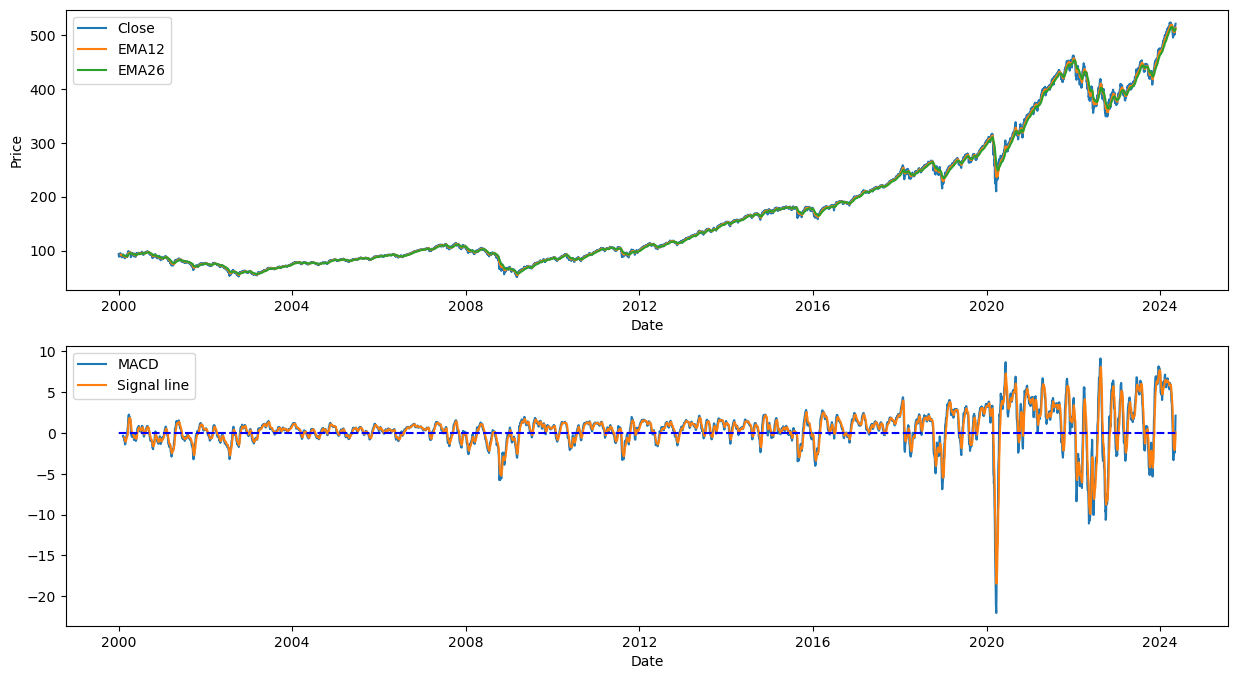

In [9]:
plt.figure(figsize = (15,8))
plt.subplot(2,1,1)
plt.plot(spy.index, spy['Close'], label = 'Close')
plt.plot(spy.index, spy['EMA12'], label = 'EMA12')
plt.plot(spy.index, spy['EMA26'], label = 'EMA26')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.subplot(2,1,2)
plt.plot(spy.index, spy['MACD'], label ='MACD')
plt.plot(spy.index, spy['Signal_line'], label='Signal line')
plt.plot(spy.index, np.zeros(len(spy)), 'b--')
plt.xlabel('Date')
plt.legend()
plt.show()

In [10]:
spy['Equity'] = 100000 # Create a column for Money/Balance.

### Make a new dataframe.

In [11]:
df2 = spy

In [12]:
df2 = df2.copy() # Make a copy to avoid copy warnings.

### Define/Create the buy and sell signals.

In [13]:
# Create two empty list for buy and sell signals
# Define a array filled with zeros with length of dataframe.
# Create two Columns for the Bought ant Sold prices.
buy_signals = []
sell_signals = []
Trigger = np.zeros(len(df2))
df2['Bought'] = 0
df2['Sold'] = 0

# For loop to "calculate" the signals.
for i in range(len(df2)):

    # Define the conditions for buy signals.
    # If the Signal line cross the MACD line from below and the Trigger was not 1 (we did not have any ETF) on the day before
    # and the Signal line value on the day before is less than -1.5 then invest/buy ETFs (Oversold).
    # If the present Close price is the highest in the last 26 day then invest/buy ETFs.

    if( (df2['Signal_line'].iloc[i] > df2['MACD'].iloc[i] and df2['Signal_line'].iloc[i-1] < df2['MACD'].iloc[i-1] and
    df2['Signal_line'].iloc[i-2] < df2['MACD'].iloc[i-2] and Trigger[i-1] != 1 and df2['Signal_line'].iloc[i-1] <= -1.5) or
       (df2['Max'].iloc[i-1] == df2['Close'].iloc[i] and i > 50 and Trigger[i-1] != 1)):
        sell_signals.append(float('nan'))            # Append a nan value to the sell signal list.
        buy_signals.append(df2['Close'].iloc[i])     # Append the close price value to the buy signal list.
        df2['Bought'].iloc[i] = df2['Close'].iloc[i] # Append the close price value to the Bought column.
        Trigger[i] = 1                               # Change the Trigger value to 1 (we have ETF)

    # Define the conditions for sell signals.
    # If the Signal line cross the MACD line from above and the Trigger was 1 (we have ETF)
    # and the Signal line value on the day before is greater than 1.5 then sell the ETFs (Overbought).
    # If the present Close price is the lowest in the last 26 day then sell ETFs.

    elif ((df2['Signal_line'].iloc[i] < df2['MACD'].iloc[i] and df2['Signal_line'].iloc[i-1] > df2['MACD'].iloc[i-1] and
    df2['Signal_line'].iloc[i-2] > df2['MACD'].iloc[i-2] and Trigger[i-1] == 1 and df2['Signal_line'].iloc[i-1] >= 1.5 and
    (df2['Close'].iloc[i] > df2['Bought'].iloc[i-1]))
    or (df2['Min'].iloc[i-1] == df2['Close'].iloc[i] and i > 50 and Trigger[i-1] == 1)):
        buy_signals.append(float('nan'))           # Append a nan value to the buy signal list.
        sell_signals.append(df2['Close'].iloc[i])  # Append the close price value to the sell signal list.
        df2['Sold'].iloc[i] = df2['Close'].iloc[i] # Append the close price value to the Sold column.
        Trigger[i] = -1                            # Change the Trigger to -1 (we sell the ETFs)

    # If the conditions is not fulfilled then append a nan value to both Sell and Buy signal lists.
    # And the Trigger current value is still the same. (We don't do anything.)

    else:
        buy_signals.append(float('nan'))
        sell_signals.append(float('nan'))
        Trigger[i] = Trigger[i-1]
        df2['Bought'].iloc[i] = df2['Bought'].iloc[i-1]
        df2['Sold'].iloc[i] = df2['Sold'].iloc[i-1]

C:\Users\traue\AppData\Local\Temp\ipykernel_12888\1180296450.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Bought'].iloc[i] = df2['Bought'].iloc[i-1]
C:\Users\traue\AppData\Local\Temp\ipykernel_12888\1180296450.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Sold'].iloc[i] = df2['Sold'].iloc[i-1]
C:\Users\traue\AppData\Local\Temp\ipykernel_12888\1180296450.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['

### Create columns from the created lists and array.

In [14]:
df2['Buy'] = buy_signals
df2['Sell'] = sell_signals
df2['Trigger'] = Trigger

### Plot the close price and the Buy and Sell signals.

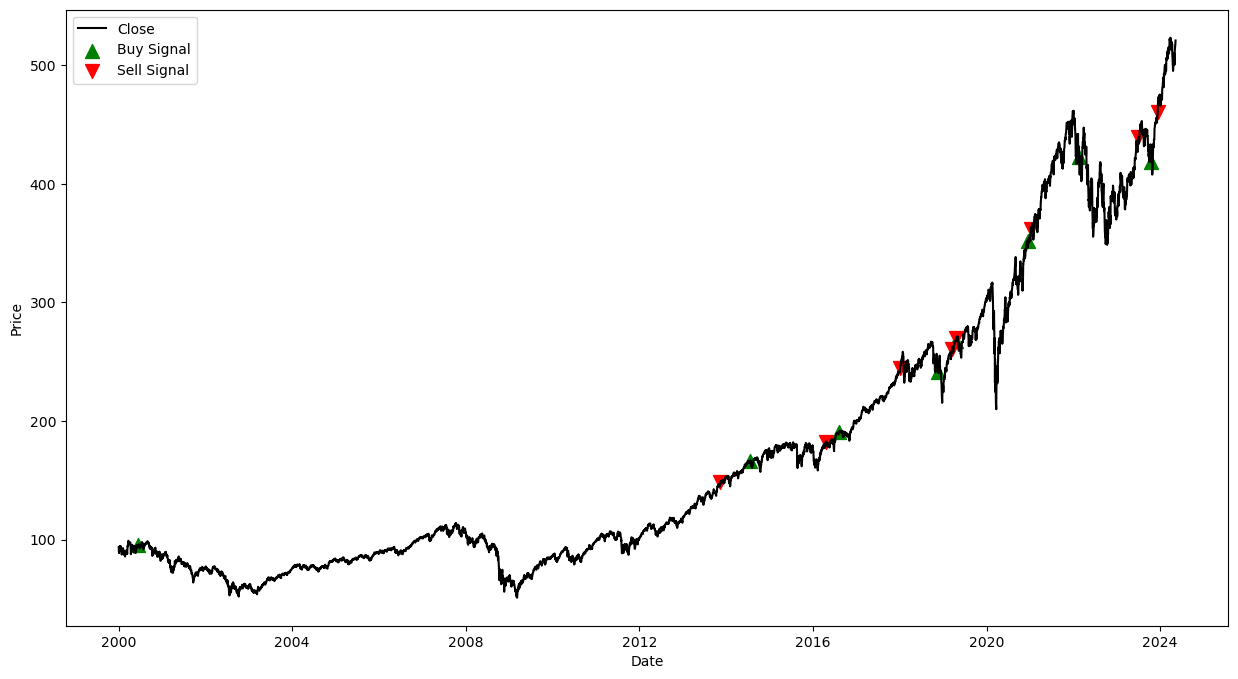

In [15]:
plt.figure(figsize=(15,8))
plt.plot(df2.index, df2['Close'], label = 'Close', color='k')
plt.scatter(df2.index, df2['Buy'], label = 'Buy Signal', marker = '^', color='g', s=100)
plt.scatter(df2.index, df2['Sell'], label = 'Sell Signal', marker = 'v', color='r', s=100)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Write a for loop to calculate the Equity
#### The first day we have 100000 USD
#### If the Trigger =  0 or -1  then our balance is still the same.
#### If the Trigger  = 1 and the yesterday's Trigger was not equal to 1 then we invest/buy ETFs (calculate the cost of transaction)
#### If the Trigger  = -1 and the yesterday's Trigger was not equal to -1 then we sell ETFs (calculate the cost of transaction)
#### If the Trigger  = 1 and the yesterday's Trigger was equal to 1 then:
#### Equity(today) = Close(today)/Close(yesterday)*Equity(yesterday)

C:\Users\traue\AppData\Local\Temp\ipykernel_12888\185587130.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Equity'].iloc[i] = 100000
C:\Users\traue\AppData\Local\Temp\ipykernel_12888\185587130.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Equity'].iloc[i] = df2['Equity'].iloc[i-1]
C:\Users\traue\AppData\Local\Temp\ipykernel_12888\185587130.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Equity'].iloc[i] =

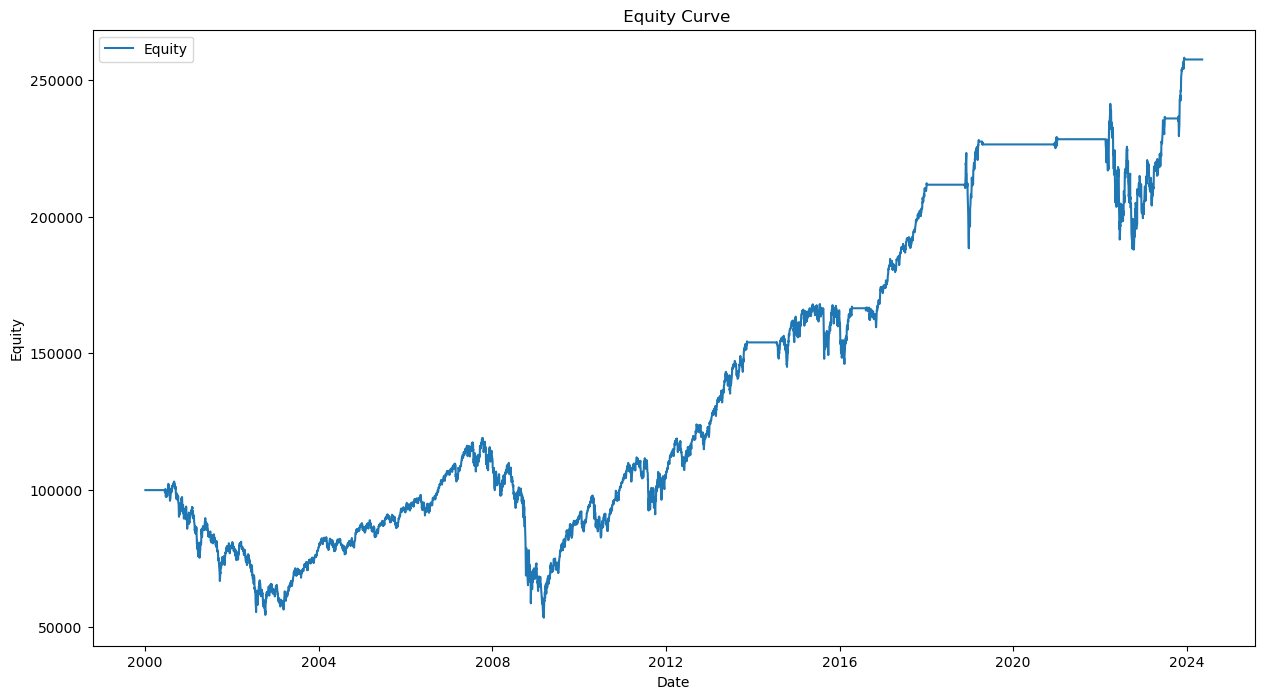

In [16]:

for i in range(len(df2)):
    if i == 0:
        df2['Equity'].iloc[i] = 100000
    elif df2['Trigger'].iloc[i] == -1 and df2['Trigger'].iloc[i-1] == 1:
        df2['Equity'].iloc[i] = df2['Equity'].iloc[i-1]*0.9975
    elif df2['Trigger'].iloc[i] == 0 and i>=1:
        df2['Equity'].iloc[i] = df2['Equity'].iloc[i-1]
    elif df2['Trigger'].iloc[i] == -1 and i>=1:
        df2['Equity'].iloc[i] = df2['Equity'].iloc[i-1]
    elif df2['Trigger'].iloc[i] == 1 and df2['Trigger'].iloc[i-1] != 1:
        df2['Equity'].iloc[i] = df2['Equity'].iloc[i-1]*0.9975
    elif df2['Trigger'].iloc[i-1] == 1 and df2['Trigger'].iloc[i] == 1:
        df2['Equity'].iloc[i] = df2['Close'].iloc[i]/df2['Close'].iloc[i-1]*df2['Equity'].iloc[i-1]
plt.figure(figsize=(15,8))
plt.plot(df2.index, df2['Equity'], label = 'Equity')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title(' Equity Curve')
plt.legend()
plt.show()

### Plot our Equity over time

### Calculate the change of Close price per day then plot the result


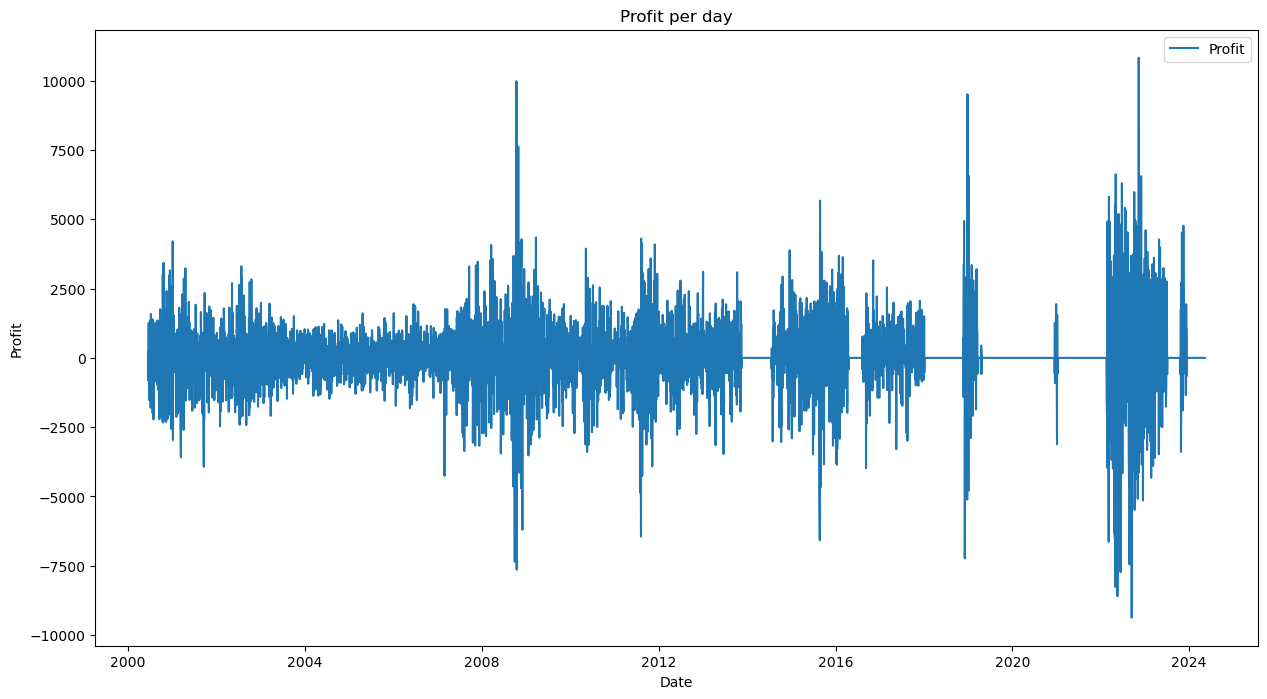

In [17]:
Profit = []


for i in range(len(df2)):
    if df2['Trigger'].iloc[i] != 0:
        Profit.append(df2['Equity'].iloc[i] - df2['Equity'].iloc[i-1])
    else:
        Profit.append(float('nan'))

df2['Profit'] = Profit

plt.figure(figsize=(15,8))
plt.plot(df2.index, df2['Profit'], label = 'Profit')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.title('Profit per day')
plt.legend()
plt.show()

### Plot the distribution of the "Profit"

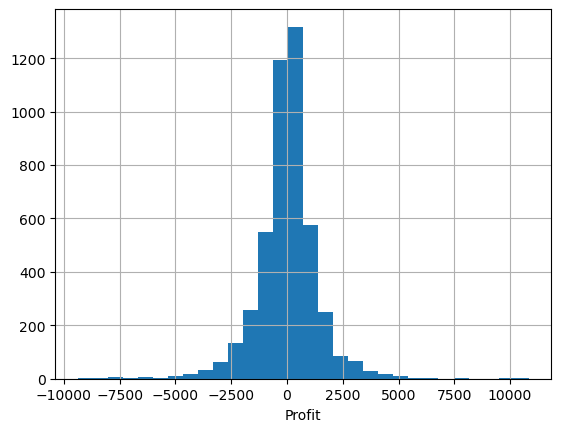

In [18]:
df2_new = df2[df2['Profit']!=0]
df2_new.Profit.hist(bins=30)
plt.xlabel('Profit')
plt.show()

In [19]:
print(f'Mean of Profits:{round(df2.Profit.mean(),2)}')
print(f'Std of Profits:{round(df2.Profit.std(),2)}')
print(f'Median of Profits:{round(df2.Profit.median(),2)}')
print(f'Sum of Profits:{round(df2.Profit.sum(),2)}')

Mean of Profits:26.17
Std of Profits:1211.51
Median of Profits:0.0
Sum of Profits:157398.55


C:\Users\traue\AppData\Local\Temp\ipykernel_12888\2032356456.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Equity_base'].iloc[i] = 100000 * 0.9975
C:\Users\traue\AppData\Local\Temp\ipykernel_12888\2032356456.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Equity_base'].iloc[i] = df2['Close'].iloc[i]/df2['Close'].iloc[i-1]*df2['Equity_base'].iloc[i-1]


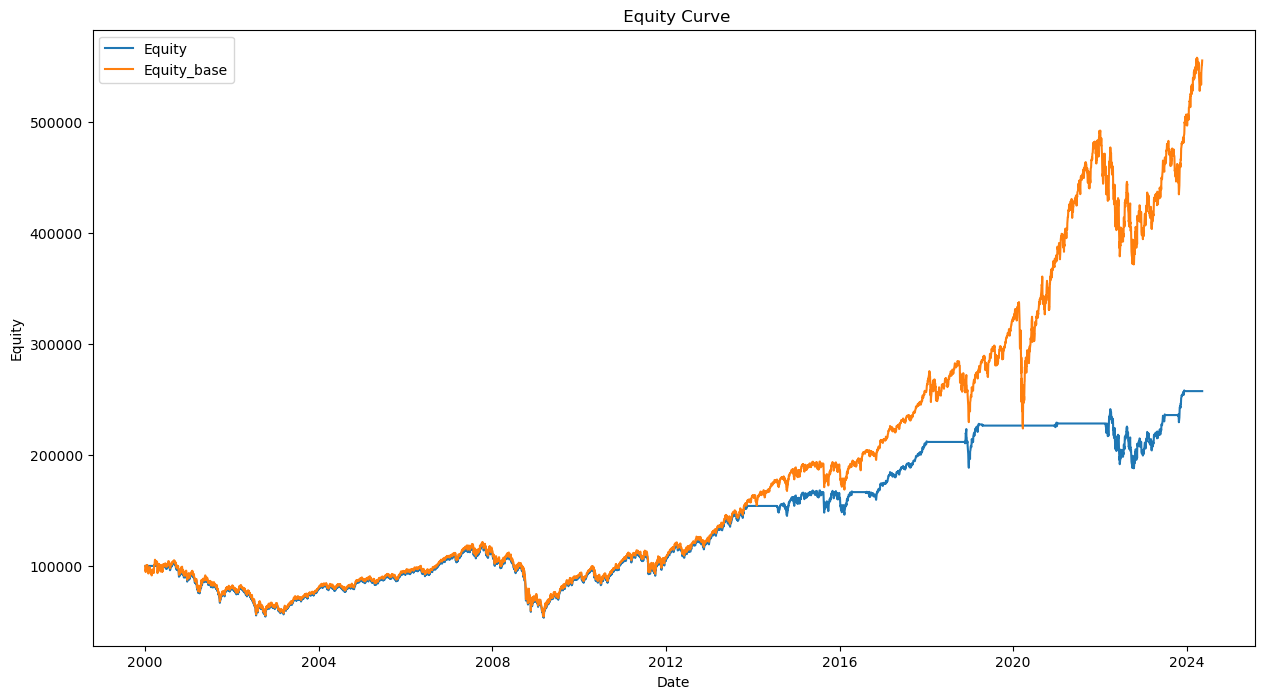

In [20]:

df2['Equity_base'] = 100000
for i in range(len(df2)):
    if i == 0:
        df2['Equity_base'].iloc[i] = 100000 * 0.9975
    else:
        df2['Equity_base'].iloc[i] = df2['Close'].iloc[i]/df2['Close'].iloc[i-1]*df2['Equity_base'].iloc[i-1]

plt.figure(figsize=(15,8))
plt.plot(df2.index, df2['Equity'], label = 'Equity')
plt.plot(df2.index, df2['Equity_base'], label = 'Equity_base')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title(' Equity Curve')
plt.legend()
plt.show()

## Second algorithm

### Same steps as before.

In [21]:
spy2 = yf.Ticker('SPY').history(period='max')  # Get the history data of 'SPY'.
spy2

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
1993-01-29 00:00:00-05:00,24.781361,24.781361,24.658071,24.763748,1003200,0.0,0.0,0.0
1993-02-01 00:00:00-05:00,24.781358,24.939875,24.781358,24.939875,480500,0.0,0.0,0.0
1993-02-02 00:00:00-05:00,24.922251,25.010315,24.869412,24.992702,201300,0.0,0.0,0.0
1993-02-03 00:00:00-05:00,25.027935,25.274516,25.010322,25.256903,529400,0.0,0.0,0.0
1993-02-04 00:00:00-05:00,25.344947,25.415399,25.063141,25.362560,531500,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-05-06 00:00:00-04:00,513.750000,516.609985,513.299988,516.570007,47264700,0.0,0.0,0.0
2024-05-07 00:00:00-04:00,517.559998,518.570007,516.450012,517.140015,52561300,0.0,0.0,0.0
2024-05-08 00:00:00-04:00,515.260010,517.739990,515.140015,517.190002,42047200,0.0,0.0,0.0


In [22]:
spy2 = spy2['2000-01-01':]
spy2 = spy2.copy() # Make a copy to avoid copy warnings.

In [23]:
spy2["EMA12"] = ta.ema(spy2["Close"], length=12)     # Calculate EMA with length of 12.
spy2["EMA26"] = ta.ema(spy2["Close"], length=26)     # Calculate EMA with length of 26.
spy2['MACD'] = spy2['EMA12'] - spy2['EMA26']         # Calculate the MACD.
spy2['Signal_line'] = ta.ema(spy2["MACD"], length=9) # Signal line is the EMA of MACD with a length of 9.
spy2['Equity'] = 100000                              # Create a column for Money/Balance.
spy2['Max'] = spy2.Close.rolling(26).max()           # Calculate the maximum Close price in the last 26 day.
spy2['Min'] = spy2.Close.rolling(26).min()           # Calculate the minimum Close price in the last 26 day.

In [24]:
spy2['RSI'] = ta.rsi(spy2['Close'])

In [25]:
buy_signals = []
sell_signals = []
Trigger = np.zeros(len(spy2))
spy2['Bought'] = 0
spy2['Sold'] = 0

# For loop to "calculate" the signals.
for i in range(len(spy2)):
    
    # Define the conditions for buy signals.
    # If the Signal line cross the MACD line from below and the Trigger was not 1 (we did not have any ETF) on the day before
    # and the Signal line value on the day before is less than -1.5 then invest/buy ETFs (Oversold).
    # If the RSI value is higher than 75 then buy ETFs.
    # If the present Close price is the highest in the last 26 day then invest/buy ETFs.
    
    if ((spy2['RSI'].iloc[i] > 75 and Trigger[i-1]!=1) or (spy2['Signal_line'].iloc[i] > spy2['MACD'].iloc[i] and spy2['Signal_line'].iloc[i-1] < spy2['MACD'].iloc[i-1] and
    spy2['Signal_line'].iloc[i-2] < spy2['MACD'].iloc[i-2] and Trigger[i-1] != 1 and spy2['Signal_line'].iloc[i-1] <= -1.5) or
    (spy2['Max'].iloc[i-1] == spy2['Close'].iloc[i] and i > 50 and Trigger[i-1] != 1)):
        sell_signals.append(float('nan'))              # Append a nan value to the sell signal list.
        buy_signals.append(spy2['Close'].iloc[i])      # Append the close price value to the buy signal list.
        spy2['Bought'].iloc[i] = spy2['Close'].iloc[i] # Append the close price value to the Bought column.
        Trigger[i] = 1                                 # Change the Trigger value to 1 (we have ETF)
    
    # Define the conditions for sell signals.
    # If the Signal line cross the MACD line from above and the Trigger was 1 (we have ETF)
    # and the Signal line value on the day before is greater than 1.5 then sell the ETFs (Overbought).
    # If the RSI value is lower than 25 then sell ETFs.
    # If the present Close price is the lowest in the last 26 day then sell ETFs.
    
    elif ((spy2['RSI'].iloc[i] < 25 and Trigger[i-1] == 1) or (spy2['Signal_line'].iloc[i] < spy2['MACD'].iloc[i] and spy2['Signal_line'].iloc[i-1] > spy2['MACD'].iloc[i-1] and
    spy2['Signal_line'].iloc[i-2] > spy2['MACD'].iloc[i-2] and Trigger[i-1] == 1 and
    spy2['Signal_line'].iloc[i-1] >= 1.5 and (spy2['Close'].iloc[i] > spy2['Bought'].iloc[i-1])) or
    (spy2['Min'].iloc[i-1] == spy2['Close'].iloc[i] and i > 50 and Trigger[i-1] == 1)):
        buy_signals.append(float('nan'))             # Append a nan value to the buy signal list.
        sell_signals.append(spy2['Close'].iloc[i])   # Append the close price value to the sell signal list.
        spy2['Sold'].iloc[i] = spy2['Close'].iloc[i] # Append the close price value to the Sold column.
        Trigger[i] = -1                              # Change the Trigger to -1 (we sell the ETFs)
    
    # If the conditions is not fulfilled then append a nan value to both Sell and Buy signal lists.
    # And the Trigger current value is still the same. (We don't do anything.)
    
    else:
        buy_signals.append(float('nan'))
        sell_signals.append(float('nan'))
        Trigger[i] = Trigger[i-1]
        spy2['Bought'].iloc[i] = spy2['Bought'].iloc[i-1]
        spy2['Sold'].iloc[i] = spy2['Sold'].iloc[i-1]

C:\Users\traue\AppData\Local\Temp\ipykernel_12888\3190696629.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy2['Bought'].iloc[i] = spy2['Bought'].iloc[i-1]
C:\Users\traue\AppData\Local\Temp\ipykernel_12888\3190696629.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy2['Sold'].iloc[i] = spy2['Sold'].iloc[i-1]
C:\Users\traue\AppData\Local\Temp\ipykernel_12888\3190696629.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s

In [26]:
spy2['Buy'] = buy_signals
spy2['Sell'] = sell_signals
spy2['Trigger'] = Trigger

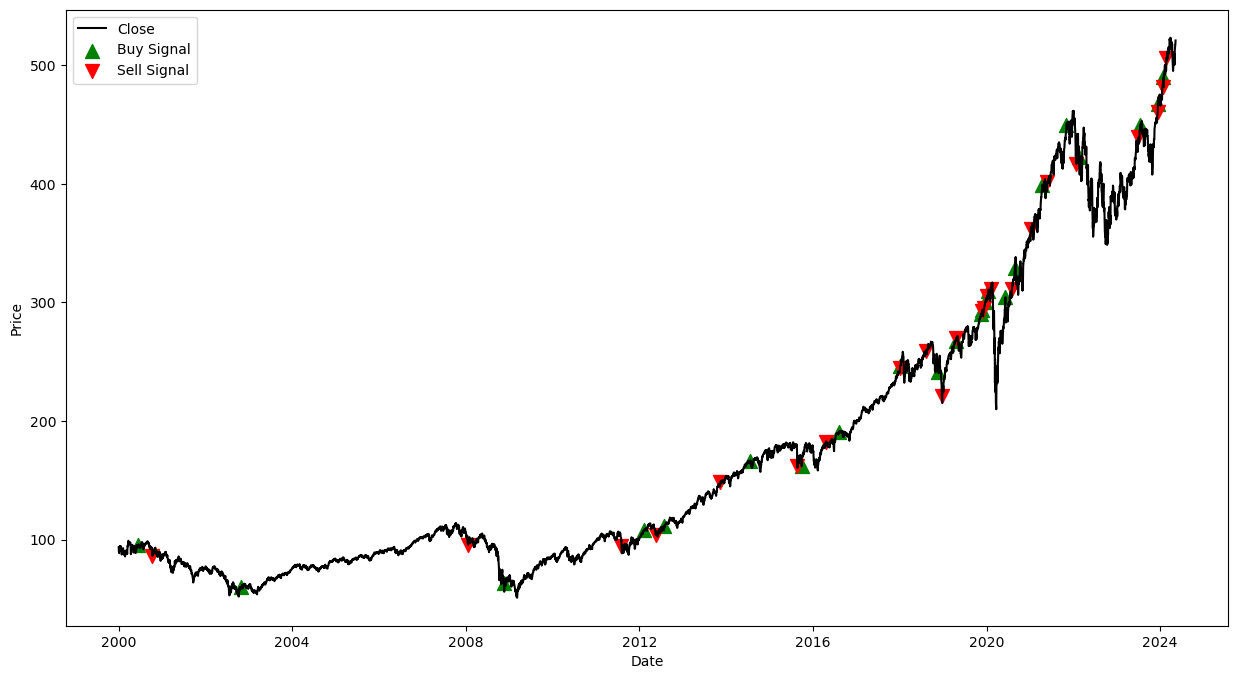

In [27]:
plt.figure(figsize=(15,8))
plt.plot(spy2.index, spy2['Close'], label = 'Close', color='k')
plt.scatter(spy2.index, spy2['Buy'], label = 'Buy Signal', marker = '^', color='g', s=100)
plt.scatter(spy2.index, spy2['Sell'], label = 'Sell Signal', marker = 'v', color='r', s=100)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

C:\Users\traue\AppData\Local\Temp\ipykernel_12888\784838440.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy2['Equity'].iloc[i] = 100000
C:\Users\traue\AppData\Local\Temp\ipykernel_12888\784838440.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy2['Equity'].iloc[i] = spy2['Equity'].iloc[i-1]
C:\Users\traue\AppData\Local\Temp\ipykernel_12888\784838440.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy2['Equity'].iloc[

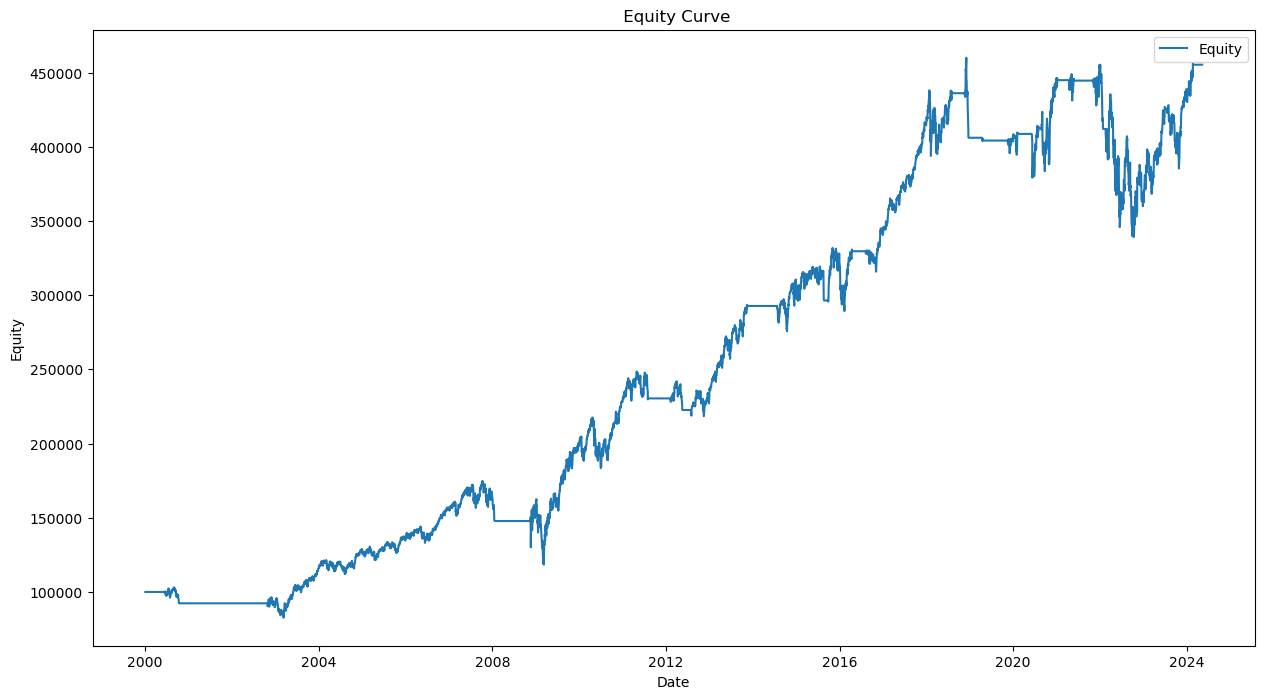

In [28]:

for i in range(len(spy2)):
    if i == 0:
        spy2['Equity'].iloc[i] = 100000
    elif spy2['Trigger'].iloc[i] == -1 and spy2['Trigger'].iloc[i-1] == 1:
        spy2['Equity'].iloc[i] = spy2['Equity'].iloc[i-1]*0.9975
    elif spy2['Trigger'].iloc[i] == 0 and i>=1:
        spy2['Equity'].iloc[i] = spy2['Equity'].iloc[i-1]
    elif spy2['Trigger'].iloc[i] == -1 and i>=1:
        spy2['Equity'].iloc[i] = spy2['Equity'].iloc[i-1]
    elif spy2['Trigger'].iloc[i] == 1 and spy2['Trigger'].iloc[i-1] != 1:
        spy2['Equity'].iloc[i] = spy2['Equity'].iloc[i-1]*0.9975
    elif spy2['Trigger'].iloc[i-1] == 1 and spy2['Trigger'].iloc[i] == 1:
        spy2['Equity'].iloc[i] = spy2['Close'].iloc[i]/spy2['Close'].iloc[i-1]*spy2['Equity'].iloc[i-1]

plt.figure(figsize=(15,8))
plt.plot(spy2.index, spy2['Equity'], label = 'Equity')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title(' Equity Curve')
plt.legend()
plt.show()

### Plot our Equity over time

### Calculate the change of Close price per day then plot the result


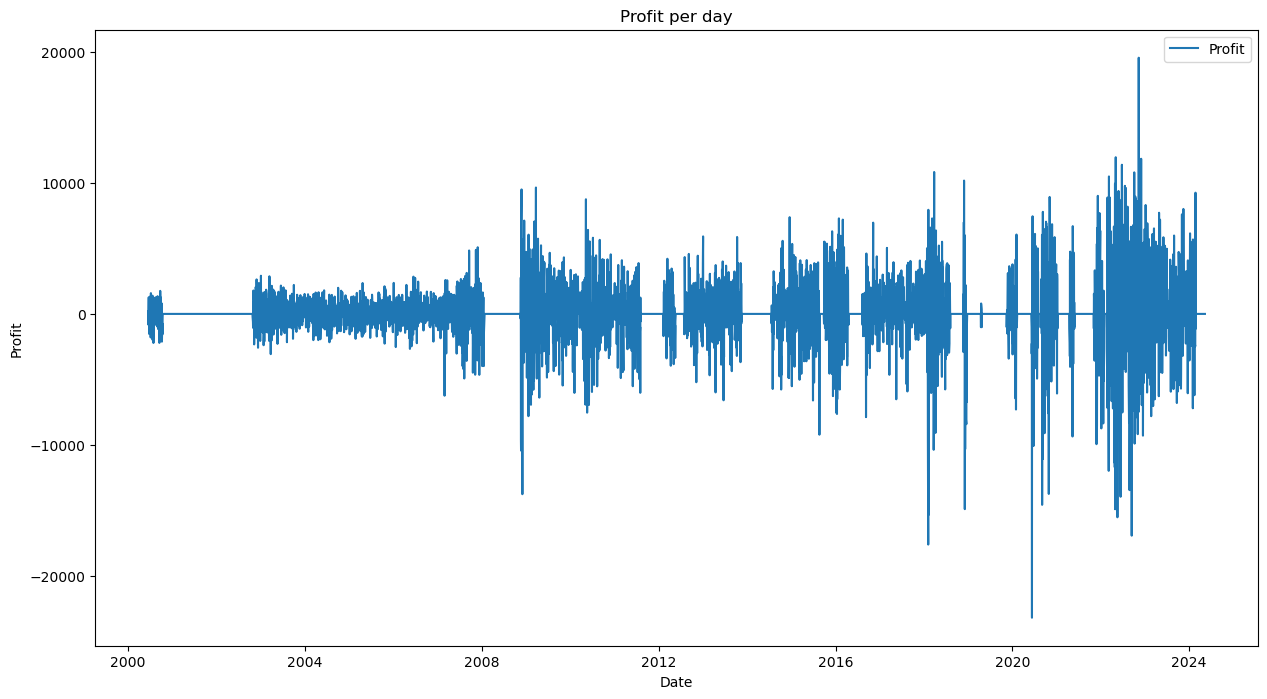

In [29]:
Profit = []


for i in range(len(spy2)):
    if spy2['Trigger'].iloc[i] != 0:
        Profit.append(spy2['Equity'].iloc[i] - spy2['Equity'].iloc[i-1])
    else:
        Profit.append(float('nan'))

spy2['Profit'] = Profit

plt.figure(figsize=(15,8))
plt.plot(spy2.index, spy2['Profit'], label = 'Profit')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.title('Profit per day')
plt.legend()
plt.show()

### Plot the distribution of the "Profit"

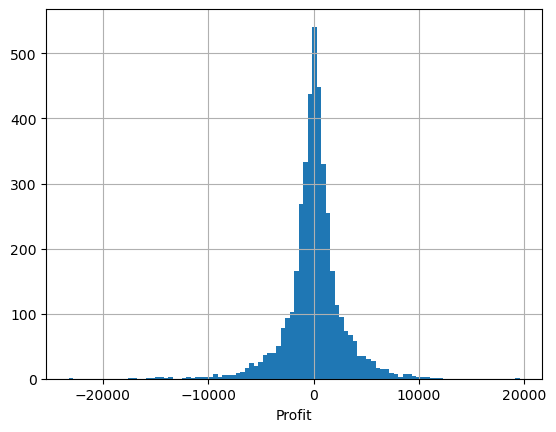

In [30]:
spy2_new = spy2[spy2['Profit']!=0]
spy2_new.Profit.hist(bins=100)
plt.xlabel('Profit')
plt.show()

In [31]:
print(f'Mean of Profits:{round(spy2.Profit.mean(),2)}')
print(f'Std of Profits:{round(spy2.Profit.std(),2)}')
print(f'Median of Profits:{round(spy2.Profit.median(),2)}')
print(f'Sum of Profits:{round(spy2.Profit.sum(),2)}')

Mean of Profits:59.07
Std of Profits:2233.96
Median of Profits:0.0
Sum of Profits:355316.8


C:\Users\traue\AppData\Local\Temp\ipykernel_12888\4001646870.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy2['Equity_base'].iloc[i] = 100000 * 0.9975
C:\Users\traue\AppData\Local\Temp\ipykernel_12888\4001646870.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy2['Equity_base'].iloc[i] = spy2['Close'].iloc[i]/spy2['Close'].iloc[i-1]*spy2['Equity_base'].iloc[i-1]


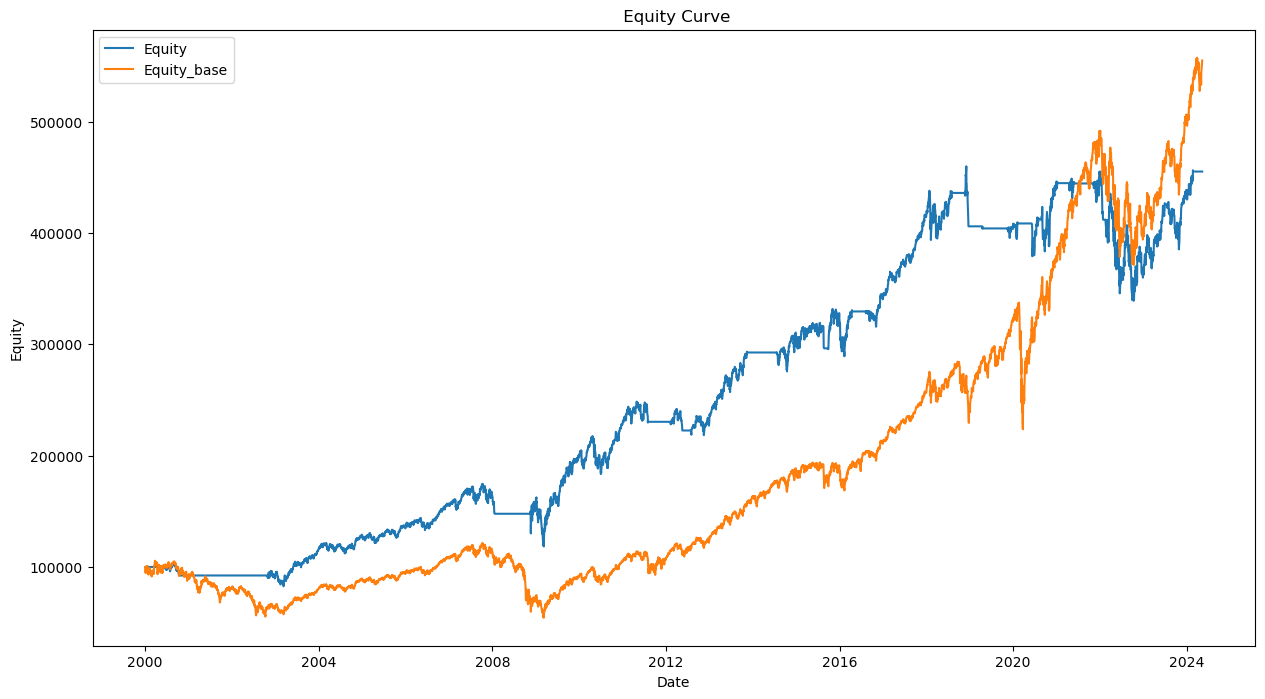

In [32]:

spy2['Equity_base'] = 100000
for i in range(len(spy2)):
    if i == 0:
        spy2['Equity_base'].iloc[i] = 100000 * 0.9975
    else:
        spy2['Equity_base'].iloc[i] = spy2['Close'].iloc[i]/spy2['Close'].iloc[i-1]*spy2['Equity_base'].iloc[i-1]

plt.figure(figsize=(15,8))
plt.plot(spy2.index, spy2['Equity'], label = 'Equity')
plt.plot(spy2.index, spy2['Equity_base'], label = 'Equity_base')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title(' Equity Curve')
plt.legend()
plt.show()

## Third Algorithm

In [33]:
spy3 = yf.Ticker('SPY').history(period='max')  # Get the history data of 'SPY'.
spy3 = spy3['2000-01-01':].copy()

In [34]:
spy3['Diff'] = spy3.Close.diff()               # Calculate the daily price changes.
spy3['Max'] = spy3.Close.rolling(26).max()     # Calculate the maximum Close price in the last 26 day.
spy3['Min'] = spy3.Close.rolling(26).min()     # Calculate the minimum Close price in the last 26 day.
spy3['RSI'] = ta.rsi(spy3['Close'])            # Calculate RSI.
spy3['Diff_std'] = 0
for i in range(len(spy3)):
    spy3['Diff_std'].iloc[i] = spy3[:i+1].Diff.std()

C:\Users\traue\AppData\Local\Temp\ipykernel_12888\1241265500.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy3['Diff_std'].iloc[i] = spy3[:i+1].Diff.std()


In [35]:
spy3['Upper'] = spy3['Close'] + (1.5 * spy3['Diff_std'])    # Define Upper, border values.
spy3['Lower'] = spy3['Close'] - (1.5 * spy3['Diff_std'])    # Define Lower, border values.

In [36]:
buy_signals = []
sell_signals = []
spy3['Bought'] = 0
spy3['Sold'] = 0
Trigger = np.zeros(len(spy3))

# For loop to "calculate" the signals.
for i in range(len(spy3)):
    
    # Define the conditions for buy signals.
    # If the close price changes in the last two days are lower than the standard deviation of changes then buy ETFs.
    # If the present Close price is the highest in the last 26 day then invest/buy ETFs.
    # If the RSI value is higher than 75 then buy ETFs.
    
    if (spy2['RSI'].iloc[i] > 75 and Trigger[i-1]!=1) or ((spy3['Close'].iloc[i] < spy3['Lower'].iloc[i-1]) and
                                                          (spy3['Close'].iloc[i-1] < spy3['Lower'].iloc[i-2])
        and Trigger[i-1] !=1) or (spy3['Max'].iloc[i-1] == spy3['Close'].iloc[i] and i > 50 and Trigger[i-1] != 1):
        sell_signals.append(float('nan'))               # Append a nan value to the sell signal list.
        buy_signals.append(spy3['Close'].iloc[i])       # Append the close price value to the buy signal list.
        spy3['Bought'].iloc[i] = spy3['Close'].iloc[i]  # Append the close price value to the Bought column.
        Trigger[i] = 1                                  # Change the Trigger value to 1 (we have ETF)
    
    # Define the conditions for sell signals.
    # If the close price changes in the last two days are higher than the standard deviation of changes then sell ETFs.
    # If the present Close price is the lowest in the last 26 day then sell ETFs.
    # If the RSI value is lower than 25 then sell ETFs.
    
    elif (spy2['RSI'].iloc[i] < 25 and Trigger[i-1] == 1) or ((spy3['Close'].iloc[i] > spy3['Upper'].iloc[i-1]) and (spy3['Close'].iloc[i-1] > spy3['Upper'].iloc[i-2])
          and (spy3['Close'].iloc[i-2] > spy3['Upper'].iloc[i-3]) and (spy3['Close'].iloc[i] > spy3['Bought'].iloc[i-1])
          and Trigger[i-1] == 1) or (spy3['Close'].iloc[i] == spy3['Min'].iloc[i-1] and Trigger[i-1] == 1):
        buy_signals.append(float('nan'))              # Append a nan value to the buy signal list.
        sell_signals.append(spy3['Close'].iloc[i])    # Append the close price value to the sell signal list.
        spy3['Sold'].iloc[i] = spy3['Close'].iloc[i]  # Append the close price value to the Sold column.
        Trigger[i] = -1                               # Change the Trigger to -1 (we sell the ETFs)
    
    # If the conditions is not fulfilled then append a nan value to both Sell and Buy signal lists.
    # And the Trigger current value is still the same. (We don't do anything.)
    
    else:
        buy_signals.append(float('nan'))
        sell_signals.append(float('nan'))
        spy3['Bought'].iloc[i] = spy3['Bought'].iloc[i-1]
        spy3['Sold'].iloc[i] = spy3['Sold'].iloc[i-1]
        Trigger[i] = Trigger[i-1]


C:\Users\traue\AppData\Local\Temp\ipykernel_12888\1487280665.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy3['Bought'].iloc[i] = spy3['Bought'].iloc[i-1]
C:\Users\traue\AppData\Local\Temp\ipykernel_12888\1487280665.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy3['Sold'].iloc[i] = spy3['Sold'].iloc[i-1]
C:\Users\traue\AppData\Local\Temp\ipykernel_12888\1487280665.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s

In [37]:
spy3['Buy'] = buy_signals
spy3['Sell'] = sell_signals
spy3['Trigger'] = Trigger

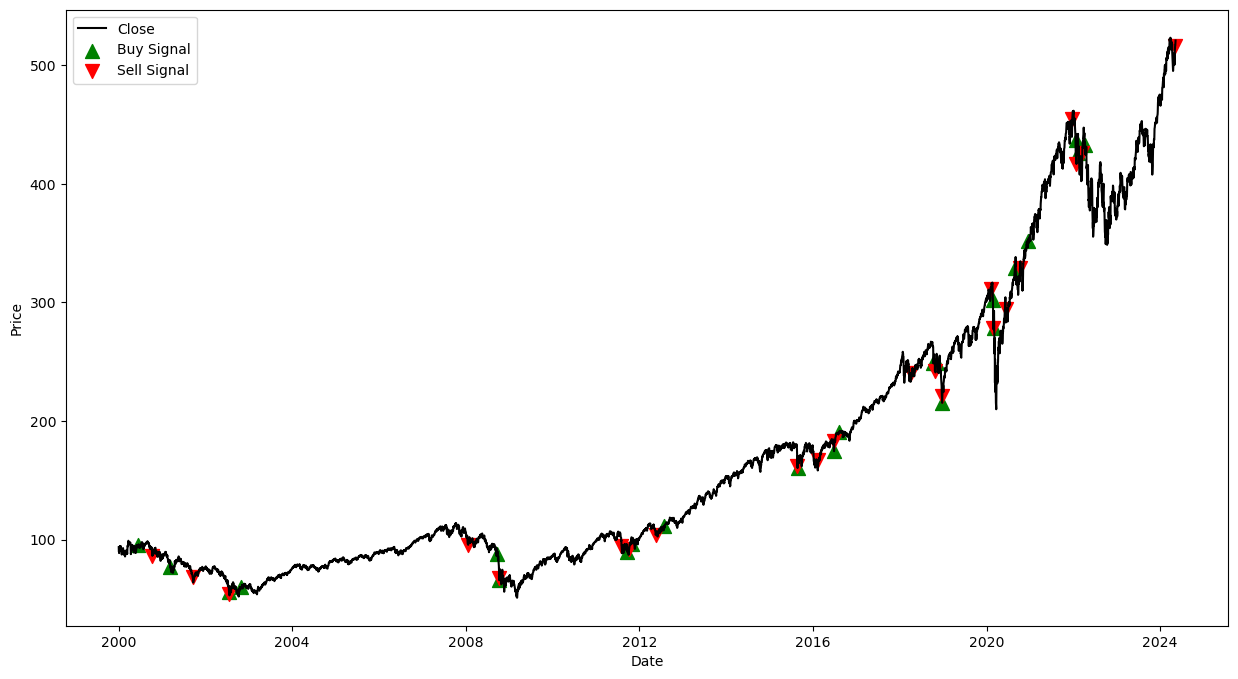

In [38]:
plt.figure(figsize=(15,8))
plt.plot(spy3.index, spy3['Close'], label = 'Close', color='k')
plt.scatter(spy3.index, spy3['Buy'], label = 'Buy Signal', marker = '^', color='g', s=100)
plt.scatter(spy3.index, spy3['Sell'], label = 'Sell Signal', marker = 'v', color='r', s=100)
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

C:\Users\traue\AppData\Local\Temp\ipykernel_12888\2741415369.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy3['Equity'].iloc[i] = 100000
C:\Users\traue\AppData\Local\Temp\ipykernel_12888\2741415369.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy3['Equity'].iloc[i] = spy3['Equity'].iloc[i-1]
C:\Users\traue\AppData\Local\Temp\ipykernel_12888\2741415369.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy3['Equity'].il

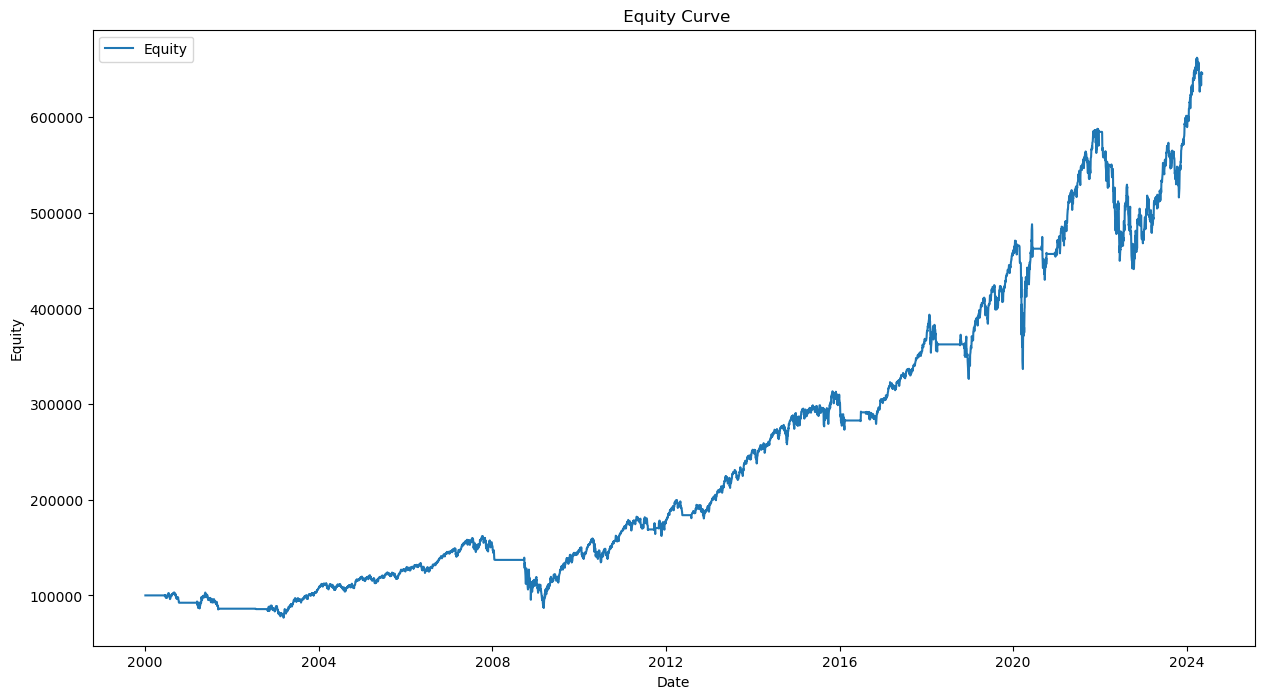

In [39]:
spy3['Equity'] = 100000
for i in range(len(spy3)):
    if i == 0:
        spy3['Equity'].iloc[i] = 100000
    elif spy3['Trigger'].iloc[i] == -1 and spy3['Trigger'].iloc[i-1] == 1:
        spy3['Equity'].iloc[i] = spy3['Equity'].iloc[i-1]*0.9975
    elif spy3['Trigger'].iloc[i] == 0 and i>=1:
        spy3['Equity'].iloc[i] = spy3['Equity'].iloc[i-1]
    elif spy3['Trigger'].iloc[i] == -1 and i>=1:
        spy3['Equity'].iloc[i] = spy3['Equity'].iloc[i-1]
    elif spy3['Trigger'].iloc[i] == 1 and spy3['Trigger'].iloc[i-1] != 1:
        spy3['Equity'].iloc[i] = spy3['Equity'].iloc[i-1]*0.9975
    elif spy3['Trigger'].iloc[i-1] == 1 and spy3['Trigger'].iloc[i] == 1:
        spy3['Equity'].iloc[i] = spy3['Close'].iloc[i]/spy3['Close'].iloc[i-1]*spy3['Equity'].iloc[i-1]

plt.figure(figsize=(15,8))
plt.plot(spy3.index, spy3['Equity'], label = 'Equity')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title(' Equity Curve')
plt.legend()
plt.show()

### Plot our Equity over time

### Calculate the change of Close price per day then plot the result


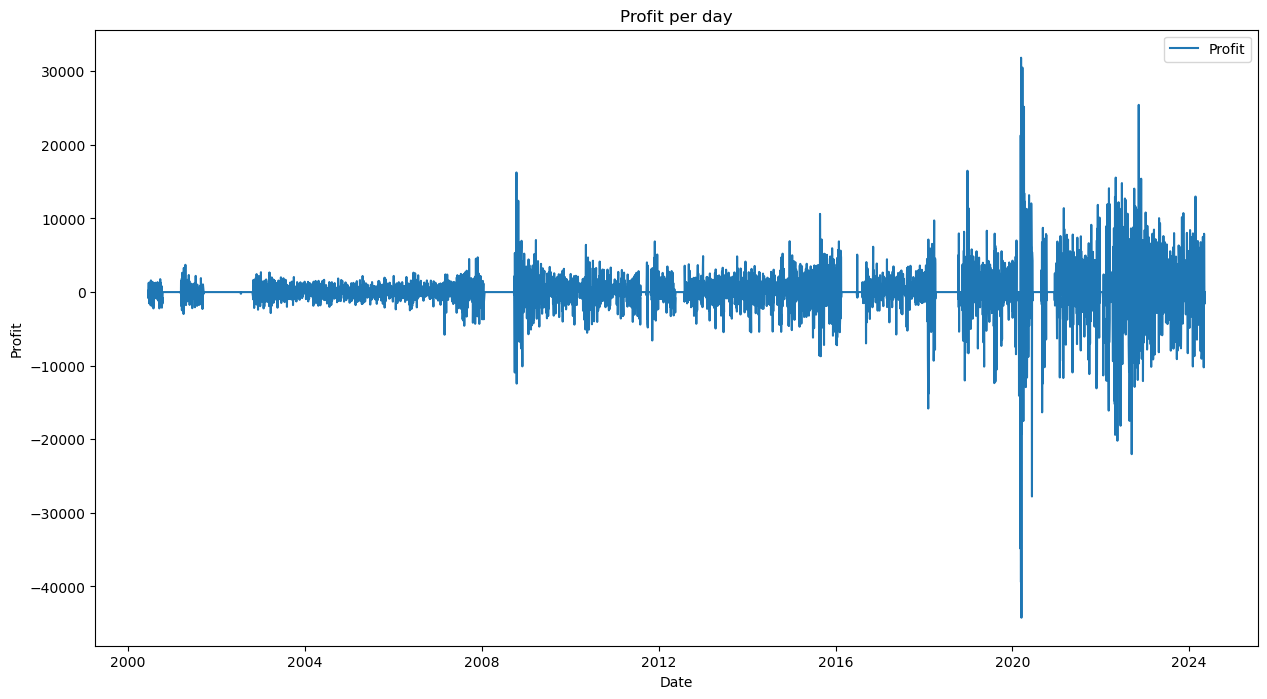

In [40]:
Profit = []


for i in range(len(spy3)):
    if spy3['Trigger'].iloc[i] != 0:
        Profit.append(spy3['Equity'].iloc[i] - spy3['Equity'].iloc[i-1])
    else:
        Profit.append(float('nan'))

spy3['Profit'] = Profit

plt.figure(figsize=(15,8))
plt.plot(spy3.index, spy3['Profit'], label = 'Profit')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.title('Profit per day')
plt.legend()
plt.show()

### Plot the distribution of the "Profit"

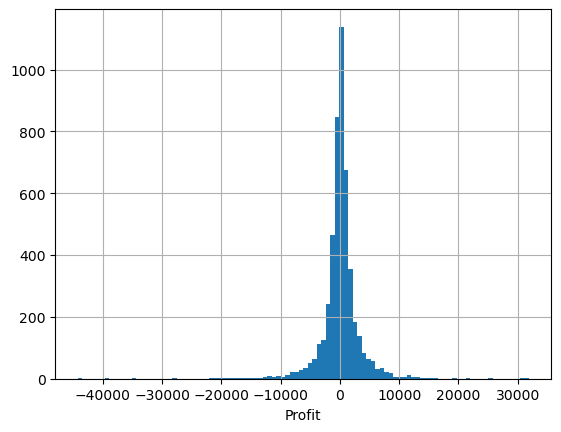

In [41]:
spy3_new = spy3[spy3['Profit']!=0]
spy3_new.Profit.hist(bins=100)
plt.xlabel('Profit')
plt.show()

In [42]:
print(f'Mean of Profits:{round(spy3.Profit.mean(),2)}')
print(f'Std of Profits:{round(spy3.Profit.std(),2)}')
print(f'Median of Profits:{round(spy3.Profit.median(),2)}')
print(f'Sum of Profits:{round(spy3.Profit.sum(),2)}')

Mean of Profits:90.7
Std of Profits:3023.59
Median of Profits:0.0
Sum of Profits:545539.63


C:\Users\traue\AppData\Local\Temp\ipykernel_12888\810544054.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy3['Base_Equity'].iloc[i] = 100000 * 0.9975
C:\Users\traue\AppData\Local\Temp\ipykernel_12888\810544054.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy3['Base_Equity'].iloc[i] = spy3['Close'].iloc[i]/spy3['Close'].iloc[i-1]*spy3['Base_Equity'].iloc[i-1]


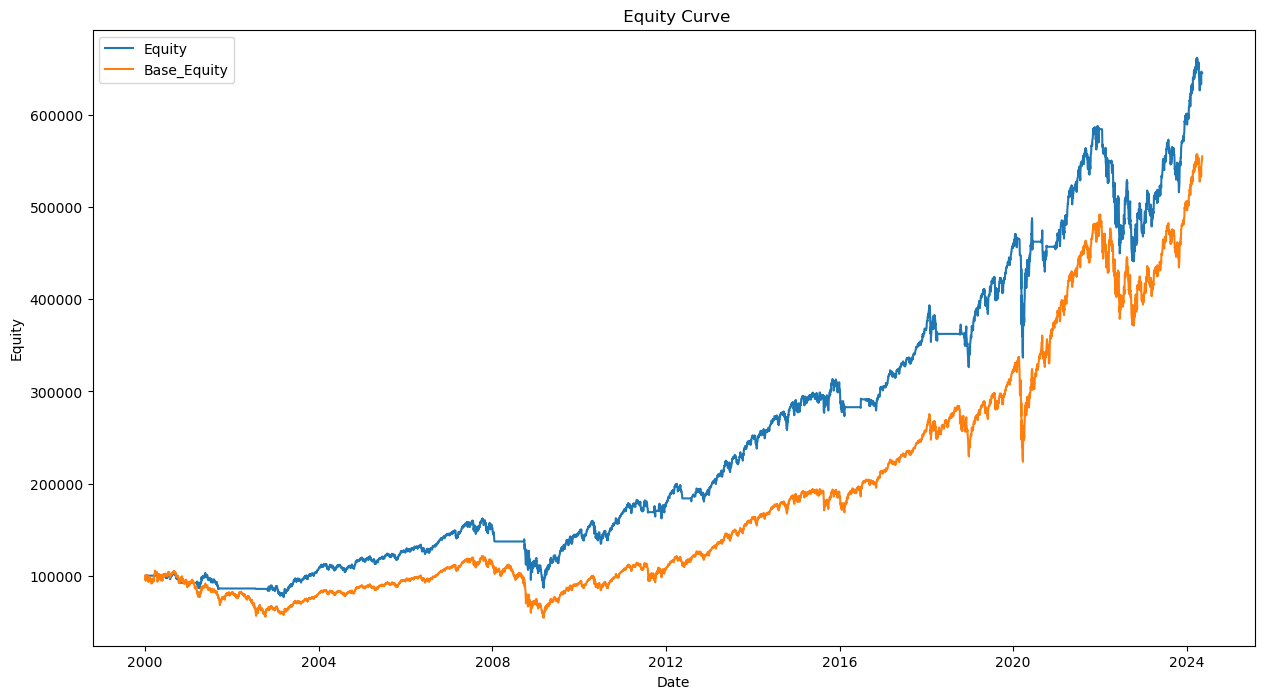

In [43]:

spy3['Base_Equity'] = 100000
for i in range(len(spy3)):
    if i == 0:
        spy3['Base_Equity'].iloc[i] = 100000 * 0.9975
    else:
        spy3['Base_Equity'].iloc[i] = spy3['Close'].iloc[i]/spy3['Close'].iloc[i-1]*spy3['Base_Equity'].iloc[i-1]

plt.figure(figsize=(15,8))
plt.plot(spy3.index, spy3['Equity'], label = 'Equity')
plt.plot(spy3.index, spy3['Base_Equity'], label = 'Base_Equity')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title(' Equity Curve')
plt.legend()
plt.show()

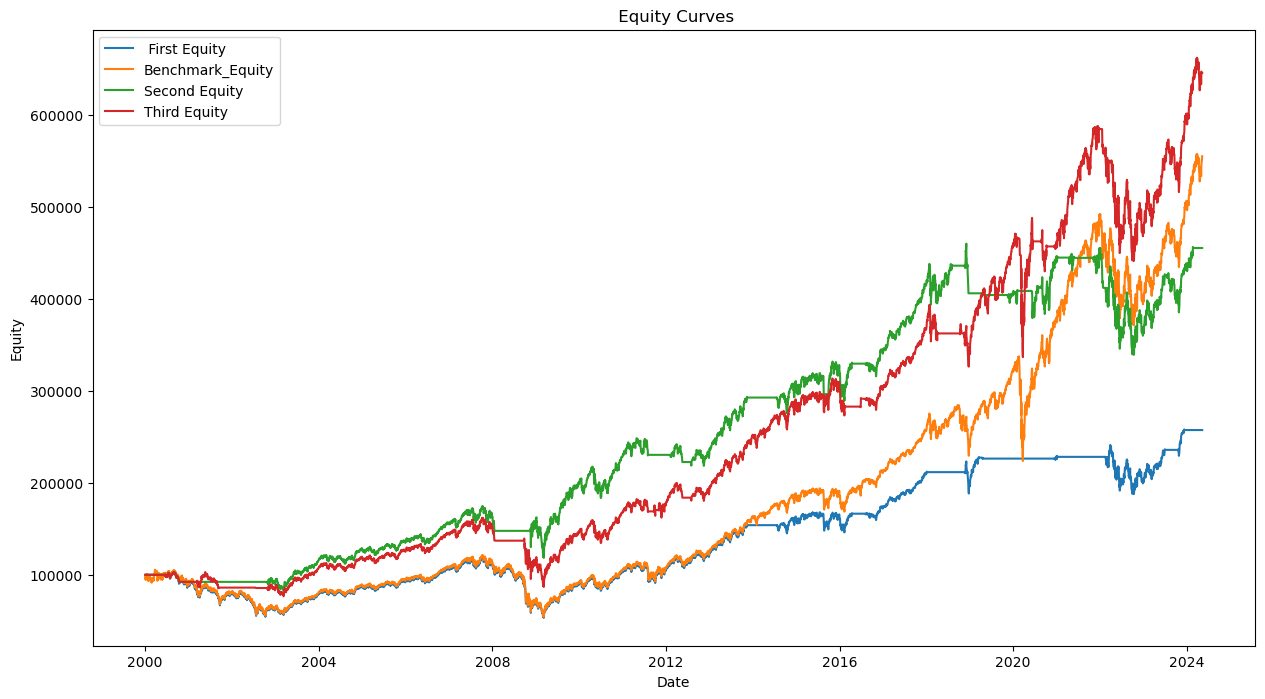

In [44]:
plt.figure(figsize=(15,8))
plt.plot(df2.index, df2['Equity'], label = ' First Equity')
plt.plot(df2.index, df2['Equity_base'], label = 'Benchmark_Equity')
plt.plot(spy2.index, spy2['Equity'], label = 'Second Equity')
plt.plot(spy3.index, spy3['Equity'], label = 'Third Equity')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.title(' Equity Curves')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Distribution of Close price changes')

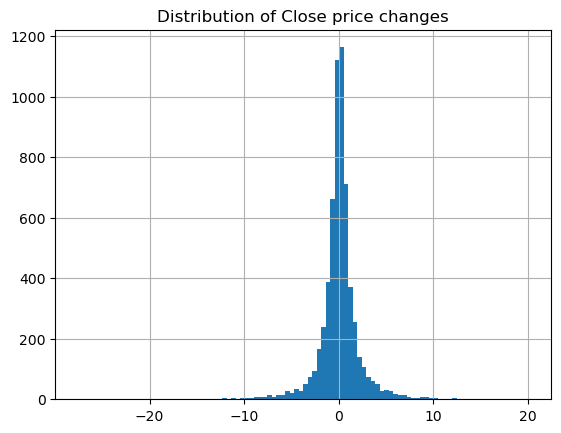

In [45]:
spy3.Diff.hist(bins=100)
plt.title('Distribution of Close price changes')